In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils  import make_grid
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [68]:
dataset = CIFAR10(root = './',train = True , transform = ToTensor(), download =True)
test_dataset = CIFAR10(root = './',train = False , transform = ToTensor())

Files already downloaded and verified


In [69]:
print(len(dataset))
print(len(test_dataset))

50000
10000


In [70]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

torch.Size([3, 32, 32])
9


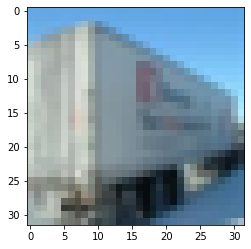

In [71]:
img,labels = dataset[15]
print(img.shape)
print(labels)
plt.imshow(img.permute(1,2,0))

In [0]:
validation_split = 0.2
val_size = int(len(dataset) * validation_split)
train_size = len(dataset) - val_size

train_ds,val_ds = random_split(dataset,[train_size,val_size])

In [0]:
batch_size = 32
train_loader = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds,batch_size=batch_size,shuffle=True,num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True,num_workers=4, pin_memory=True)

images.shape: torch.Size([32, 3, 32, 32])


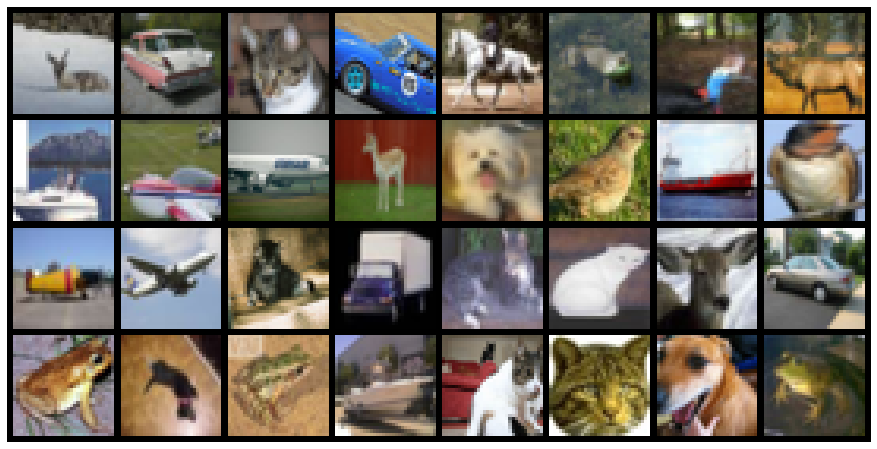

In [74]:
for images, label in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

In [0]:
input_shape = 3*32*32
num_classes = 10

In [0]:
class Cifar10(nn.Module):

  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(input_shape,64)
    self.linear2 = nn.Linear(64,128)
    self.linear3 = nn.Linear(128,256)
    self.linear4 = nn.Linear(256,512)
    self.linear5 = nn.Linear(512,num_classes)

  def forward(self,xb):
    xb = xb.reshape(-1,3072)
    out = self.linear1(xb)
    out = F.relu(out)
    out = self.linear2(out)
    out = F.relu(out)
    out = self.linear3(out)
    out = F.relu(out)
    out = self.linear4(out)
    out = F.relu(out)
    out = self.linear5(out)
    return out

  def training_step(self,batch):
    images, labels = batch 
    out = self(images)                 
    loss = F.cross_entropy(out, labels) 
    return loss

  def validation_step(self, batch):
    images, labels = batch 
    out = self(images)                  
    loss = F.cross_entropy(out, labels) 
    acc = accuracy(out, labels)          
    return {'val_loss': loss.detach(), 'val_acc': acc}
        
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()     
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


In [0]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [0]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [0]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [0]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [0]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [0]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [83]:
device = get_default_device()
device

device(type='cuda')

In [0]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [0]:
model = to_device(Cifar10(),device)

In [86]:
evaluate(model, val_loader)

{'val_acc': 0.09984025359153748, 'val_loss': 2.302886724472046}

In [87]:
history = fit(10, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 2.1400, val_acc: 0.2197
Epoch [1], val_loss: 1.9701, val_acc: 0.2673
Epoch [2], val_loss: 1.8761, val_acc: 0.3187
Epoch [3], val_loss: 1.8053, val_acc: 0.3396
Epoch [4], val_loss: 1.7677, val_acc: 0.3495
Epoch [5], val_loss: 1.7022, val_acc: 0.3860
Epoch [6], val_loss: 1.6786, val_acc: 0.3899
Epoch [7], val_loss: 1.6733, val_acc: 0.3986
Epoch [8], val_loss: 1.6316, val_acc: 0.4118
Epoch [9], val_loss: 1.5873, val_acc: 0.4315


In [88]:
history += fit(10, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 1.5618, val_acc: 0.4426
Epoch [1], val_loss: 1.5527, val_acc: 0.4452
Epoch [2], val_loss: 1.5338, val_acc: 0.4508
Epoch [3], val_loss: 1.5688, val_acc: 0.4417
Epoch [4], val_loss: 1.5575, val_acc: 0.4507
Epoch [5], val_loss: 1.4922, val_acc: 0.4660
Epoch [6], val_loss: 1.4904, val_acc: 0.4707
Epoch [7], val_loss: 1.4969, val_acc: 0.4657
Epoch [8], val_loss: 1.4525, val_acc: 0.4858
Epoch [9], val_loss: 1.4629, val_acc: 0.4820


In [89]:
history += fit(10, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 1.5075, val_acc: 0.4716
Epoch [1], val_loss: 1.4543, val_acc: 0.4864
Epoch [2], val_loss: 1.5189, val_acc: 0.4608
Epoch [3], val_loss: 1.4712, val_acc: 0.4807
Epoch [4], val_loss: 1.4182, val_acc: 0.5029
Epoch [5], val_loss: 1.4657, val_acc: 0.4814
Epoch [6], val_loss: 1.4061, val_acc: 0.5093
Epoch [7], val_loss: 1.4126, val_acc: 0.5092
Epoch [8], val_loss: 1.4277, val_acc: 0.4995
Epoch [9], val_loss: 1.4244, val_acc: 0.4991


In [90]:
history += fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.3680, val_acc: 0.5248
Epoch [1], val_loss: 1.3696, val_acc: 0.5211
Epoch [2], val_loss: 1.3691, val_acc: 0.5255
Epoch [3], val_loss: 1.3689, val_acc: 0.5209
Epoch [4], val_loss: 1.3703, val_acc: 0.5217


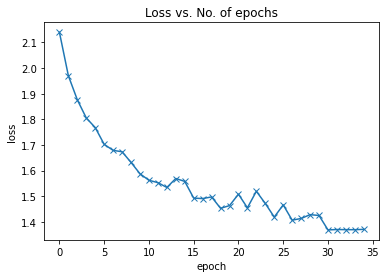

In [91]:
plot_losses(history)

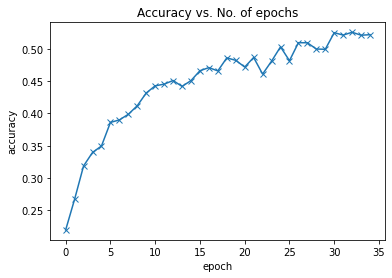

In [92]:
plot_accuracies(history)

In [93]:
evaluate(model,test_loader)

{'val_acc': 0.5236621499061584, 'val_loss': 1.3460369110107422}